Download file

In [ ]:
!gdown "1MsAjPM7oKtVfJL_wRp1qmCajtSG1mdcK"

Downloading...
From: https://drive.google.com/uc?id=1MsAjPM7oKtVfJL_wRp1qmCajtSG1mdcK
To: /content/E-commerce-public-dataset.zip
100% 44.9M/44.9M [00:00<00:00, 79.1MB/s]


In [ ]:
import shutil,os

shutil.unpack_archive("/content/E-commerce-public-dataset.zip" , "")
os.rename("E-Commerce Public Dataset", "data")

OSError: ignored

# Import library and data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
customers = pd.read_csv("data/customers_dataset.csv")
geolocation = pd.read_csv("data/geolocation_dataset.csv")
orders = pd.read_csv("data/orders_dataset.csv")
order_items = pd.read_csv("data/order_items_dataset.csv")
order_payments = pd.read_csv("data/order_payments_dataset.csv")
order_reviews = pd.read_csv("data/order_reviews_dataset.csv")
products = pd.read_csv("data/products_dataset.csv")
product_cat = pd.read_csv("data/product_category_name_translation.csv")
sellers = pd.read_csv("data/sellers_dataset.csv")

table = [customers,geolocation,orders,order_items,order_items,order_payments,order_reviews,products,product_cat,sellers]
table_name = ["customers","geolocation","orders","order_items","order_items","order_payments","order_reviews","products","product_cat","sellers"]

# Cleaning data

In [ ]:
# Delete duplicate data
geolocation.drop_duplicates(inplace=True)

indexData = products[products.product_weight_g.isna() == True].index
# Satu product bernama bebes dan satu product tidak memiliki name
products.drop(indexData , inplace=True)

datetime_column = ["order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]
for i in datetime_column:
  orders[i] = pd.to_datetime(orders[i])

order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"])


## Impute order datetime


In [ ]:
def impute_order_datetime(x,y):
    # x = target
    # y = patokan data yang membantu mencari selisih

    # Kita ambil data yang mau dihitung selisihnya untuk dicari rata-ratanya
    data = orders[[y,x]]
    # Hapus data yang kosong karena tidak bisa dihitung selisihnya
    data.dropna(inplace=True)

    # Kita cari selisihnya dan buat kolom baru bernama "time"
    time = data[x] - data[y]
    time = time.apply(lambda x: x.total_seconds())
    data["time"] = time

    # Cari rata-ratanya
    mean = round(data.time.mean())

    # Data x yang kosong kita isi dengan data y +
    for i, j in orders.iterrows():
        if pd.isna(j[x]):
            orders.at[i,x] = orders.at[i,y] + pd.to_timedelta(mean, unit='s')

impute_order_datetime("order_approved_at","order_purchase_timestamp")
impute_order_datetime("order_delivered_carrier_date","order_approved_at")
impute_order_datetime("order_delivered_customer_date","order_delivered_carrier_date")


## Impute review

In [ ]:
order_reviews["review_comment_title"].fillna("No title", inplace = True)
order_reviews["review_comment_message"].fillna("No comment", inplace = True)


## Impute product

In [ ]:
products["product_category_name"].fillna("unknown", inplace = True)
products["product_name_lenght"].fillna(round(products["product_name_lenght"].mean()), inplace = True)
products["product_description_lenght"].fillna(round(products["product_description_lenght"].mean()), inplace = True)
products["product_photos_qty"].fillna(products["product_photos_qty"].mode()[0], inplace = True)

# Ternyata ada yang memiliki berat 0
cama = products[products.product_category_name == "cama_mesa_banho"]
# Kita hilangkan yang 0 agar tidak mengganggu saat mengambil rata-rata
cama = cama[cama.product_weight_g > 0]
products["product_weight_g"] = products["product_weight_g"].apply(lambda x: round(cama["product_weight_g"].mean()) if x == 0 else x)


## delete null payment

In [ ]:
indexData = order_payments[order_payments.payment_type == "not_defined"].index
order_payments.drop(indexData , inplace=True)

## change underscore to space

In [ ]:
products["product_category_name"] = products["product_category_name"].map(lambda x: " ".join(x.split("_")))
order_payments["payment_type"] = order_payments["payment_type"].map(lambda x: " ".join(x.split("_")))


## geo analysis

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
geometry = [Point(xy) for xy in zip(geolocation['geolocation_lng'], geolocation['geolocation_lat'])]
gdf = GeoDataFrame(geolocation, geometry=geometry)

# Global plot
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);


In [ ]:
# Dari hasil plot diatas kita lihat bahwa ada data yang outliers dan kita harus menghapusnya
indexGeoOut = geolocation.query("geolocation_lng > -30 or geolocation_lat > 10").index
geolocation.drop(index=indexGeoOut, inplace=True)

In [ ]:
geometry = [Point(xy) for xy in zip(geolocation['geolocation_lng'], geolocation['geolocation_lat'])]
gdf = GeoDataFrame(geolocation, geometry=geometry)

f, ax = plt.subplots(1, figsize=(8,10))
ax.set_axis_on()

#Bazil plot
brazil = gpd.read_file("brazil/gadm36_BRA_1.shp")
gdf.plot(ax=brazil.plot(ax=ax,cmap='YlOrRd'), marker='o', color='red', markersize=2);


points = brazil.copy()
# change the geometry
points.geometry = points['geometry'].centroid
# Plot the labels
for x, y, label in zip(points.geometry.x, points.geometry.y, points.NAME_1):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), alpha=1, textcoords="offset points",color='black')



In [ ]:
# Dari hasil plot lebih dekat kita lihat bahwa ada data yang berada di air, jadi kita harus menghapusnya
indexGeoOut = geolocation.query("(geolocation_lng < -58 and geolocation_lat < -30) or geolocation_lng > -33").index
geolocation.drop(index=indexGeoOut, inplace=True)

## update data

In [ ]:
# UPDATE DATA
for i in range(len(table)):
  table[i].to_csv(f"data/{table_name[i]}.csv")

# Function for data analysis

## revenue

In [22]:
def revenue(start_date,end_date):
  df_orders = orders.query("order_status != 'canceled' & order_status != 'unavailable'")
  df_orders = df_orders.merge(order_items,on="order_id")
  df_orders["order_purchase_timestamp"] = pd.to_datetime(df_orders["order_purchase_timestamp"])
  daily_orders_df = df_orders.resample(rule="D", on='order_purchase_timestamp').agg({
          "order_id": "nunique",
          "price": "sum"
      }).reset_index()
  daily_orders_df.columns = ["date","order","revenue"]
  daily_orders_df = daily_orders_df.sort_values(by="date")
  daily_orders_df = daily_orders_df[(daily_orders_df["date"] >= str(start_date)) &
                    (daily_orders_df["date"] <= str(end_date))]
  daily_orders_df.reset_index(drop=True,inplace=True)
  return daily_orders_df

start_date = pd.to_datetime(2016/09/04)
end_date = pd.to_datetime(2018/10/17)
data_revenue = revenue(start_date,end_date)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_revenue["date"], data_revenue["order"], marker='o', linewidth=2)

SyntaxError: ignored

## payment method

([<matplotlib.patches.Wedge at 0x7a2c51206cb0>,
 [Text(-0.8381306212619132, 0.825651910146231, 'credit card'),
  Text(0.656313144560562, -0.9072867589318313, 'boleto'),
  Text(1.0787184223645132, -0.23427913096862876, 'voucher'),
  Text(1.1003007525358794, -0.0519825812458138, 'debit card')],
 [Text(-0.4819355259321384, 0.4747601119191809, '75%'),
  Text(0.3632596875721775, -0.5021698975854326, '19%'),
  Text(0.5901091063947699, -0.1281615718769325, '4%'),
  Text(0.6008578184770631, -0.028386911754972984, '2%')])

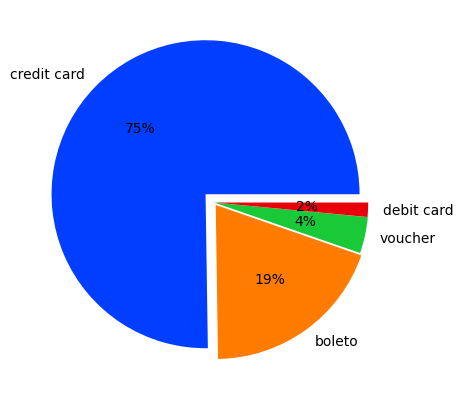

In [23]:
def payment_type():
  method = order_payments.merge(orders,on="order_id")[["order_id","payment_type","order_purchase_timestamp"]]
  # Gunakan kondisi terhadap kolom order_purchase_timestamp
  # method = method[method.order_purchase_timestamp >= ??]
  method = order_payments.groupby("payment_type").order_id.nunique().reset_index()
  method.columns = ["method","total"]
  method = method.sort_values(by="total",ascending=False)
  method.reset_index(drop=True,inplace=True)
  return method

method = payment_type()
fig, ax = plt.subplots(figsize=(5, 5))
palette_color = sns.color_palette('bright')
ax.pie(method.total, labels=method.method, colors=palette_color, explode=method.total/1000000, autopct='%.0f%%')

## product revenue

<Axes: xlabel='revenue', ylabel='category'>

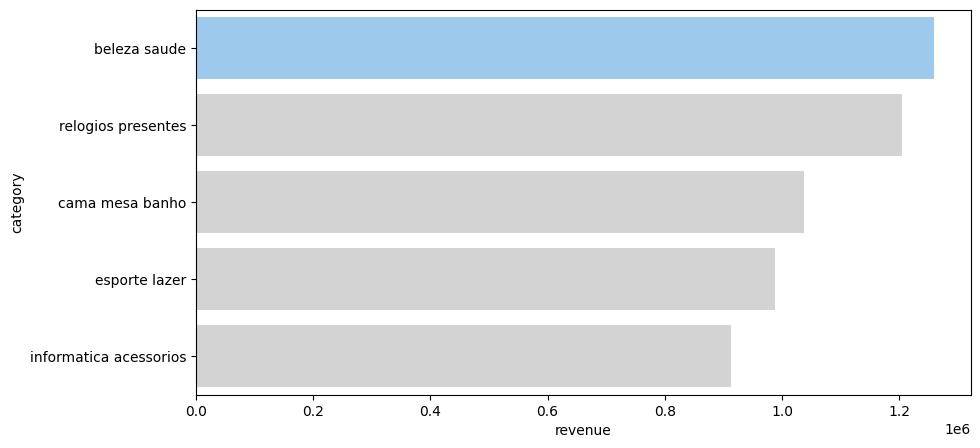

In [25]:
def product_revenue(asc):
  df_revenue = order_items.merge(products,on="product_id")
  df_revenue = df_revenue[["shipping_limit_date","product_id","price","product_category_name"]]
  df_revenue = df_revenue.groupby("product_category_name").price.sum().reset_index()
  df_revenue = df_revenue.sort_values(by="price",ascending=asc)
  df_revenue.columns = ["category","revenue"]
  df_revenue.reset_index(drop=True,inplace=True)
  return df_revenue

product_rev = product_revenue(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="revenue", y="category", data=product_rev.head(),
            label="Total", palette=colors)

## best order

In [27]:
def order(asc):
    highest = order_payments.merge(orders,on="order_id").reset_index()
    # kondisi terhadap kolom order_purchase_timestamp
    # highest = highest[highest.order_purchase_timestamp >= ??]
    highest = highest.sort_values(by="payment_value",ascending=asc)[["order_purchase_timestamp","payment_value"]]
    highest.columns = ["date","value"]
    highest.reset_index(drop=True,inplace=True)
    return highest

order(False)

,date,value
0,2017-09-29 15:24:52,13664.08
1,2018-07-15 14:49:44,7274.88
2,2017-02-12 20:37:36,6929.31
3,2018-07-25 18:10:17,6922.21
4,2017-05-24 18:14:34,6726.66
...,...,...
103878,2017-04-20 12:45:34,0.00
103879,2018-01-24 23:24:14,0.00
103880,2017-05-27 19:20:24,0.00
103881,2017-06-08 21:18:45,0.00


## biggest freight

In [29]:
def freight(asc):
    # Gunakan kondisi terhadap kolom shipping_limit_date
    # freight = order_items[order_items.shipping_limit_date >= ??]
    freight = order_items[["shipping_limit_date","price","freight_value"]]
    freight = freight.sort_values(by="freight_value",ascending=asc)
    freight.columns = ["date","price","freight"]
    freight.reset_index(drop=True,inplace=True)
    return freight

freight(False)

,date,price,freight
0,2018-04-25 06:55:13,979.00,409.68
1,2018-08-22 03:15:09,2338.08,375.28
2,2018-08-07 04:35:22,2338.08,375.28
3,2018-08-02 03:44:28,1149.00,339.59
4,2018-04-23 17:15:10,1050.00,338.30
...,...,...,...
112645,2018-05-02 20:31:14,99.90,0.00
112646,2018-05-14 20:54:48,99.90,0.00
112647,2018-05-09 16:29:23,99.90,0.00
112648,2018-05-17 17:50:55,115.00,0.00


## product weight

<Axes: xlabel='category', ylabel='weight'>

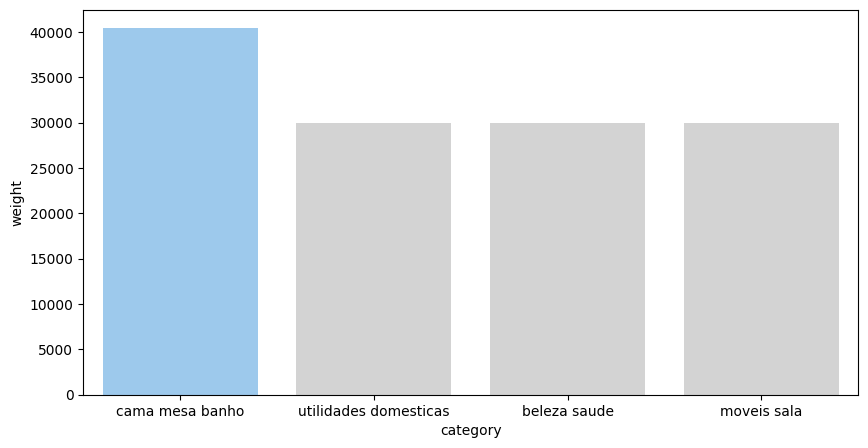

In [30]:
def weight(asc):
  weight = products.sort_values(by="product_weight_g",ascending=asc)
  weight = weight[["product_category_name","product_weight_g"]]
  weight.columns = ["category","weight"]
  weight.reset_index(drop=True,inplace=True)
  return weight

product_weight = weight(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="category", y="weight", data=product_weight.head(),
            label="Weight", palette=colors)

## product favorit

<Axes: xlabel='category', ylabel='total'>

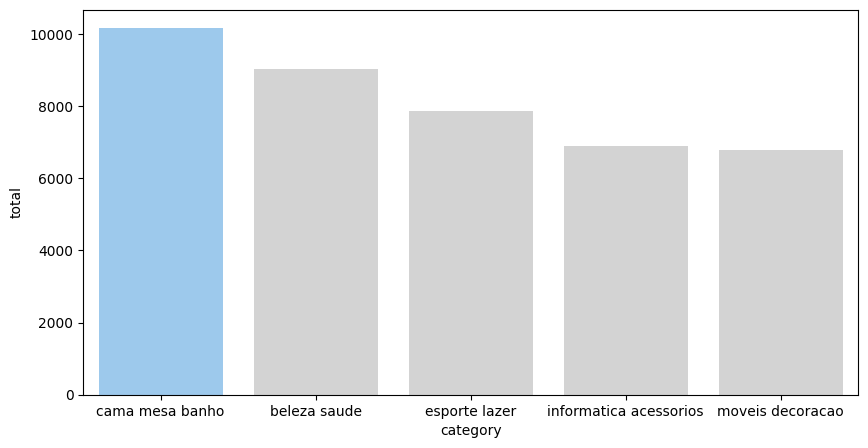

In [31]:
def favorit(asc):
    sell = order_items.groupby("product_id").order_id.nunique().reset_index()
    sell.columns = ["product_id","total"]
    sell = sell.sort_values(by="total",ascending=False)
    # Gabungkan data sell dengan table product untuk mendapatkan namanya
    df_sell = sell.merge(products,on="product_id")
    # Karena dalam satu category bisa terdapat beberapa product kiat gabungkan ke dalam satu kategori saja
    # Karena kita tidak punya nama product, hanya ada kategori
    # Kita groupby "kategori" dan tambahkan semua totalnya
    df_sell = df_sell.groupby("product_category_name").total.sum().reset_index().sort_values(by="total",ascending=asc)
    df_sell.columns = ["category","total"]
    df_sell.reset_index(drop=True,inplace=True)
    return df_sell

product_favorit = favorit(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="category", y="total", data=product_favorit.head(),
            label="Total", palette=colors)

## product quantity

<Axes: xlabel='category', ylabel='total'>

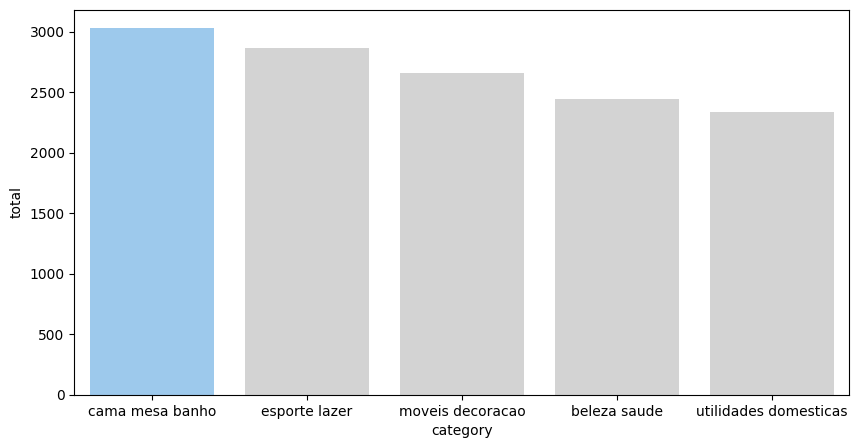

In [32]:
def quantity(asc):
    product_for_sale = products.groupby("product_category_name").product_id.nunique().reset_index()
    product_for_sale.columns = ["category","total"]
    product_for_sale = product_for_sale.sort_values(by="total",ascending=asc)
    product_for_sale.reset_index(drop=True,inplace=True)
    return product_for_sale

product_quantity = quantity(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="category", y="total", data=product_quantity.head(),
            label="Total", palette=colors)

## product price

<Axes: xlabel='category', ylabel='price'>

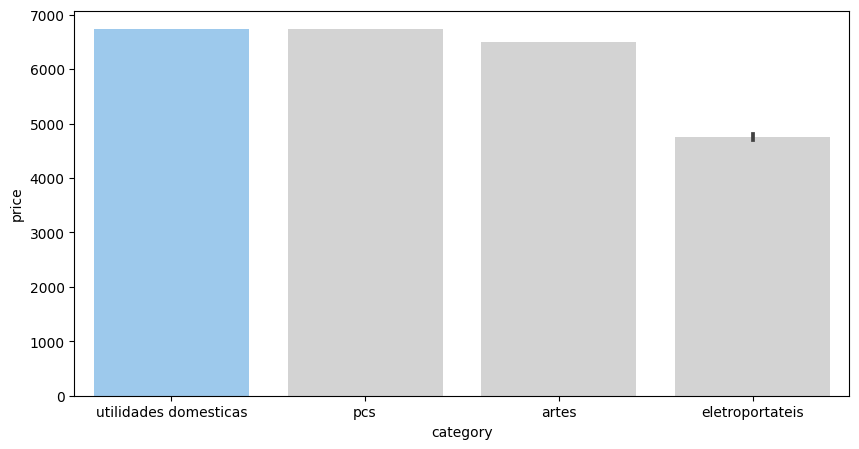

In [33]:
def price(asc):
    order = order_items[["product_id","price"]]
    price = order.merge(products,on="product_id")
    price = price[["product_category_name","price"]]
    price.columns = ["category","price"]
    price.reset_index(drop=True,inplace=True)
    return price.sort_values(by="price",ascending=asc)

product_price = price(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="category", y="price", data=product_price.head(),
          label="Price", palette=colors)

## product size

<ipython-input-34-73a6435b3315>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_volume["volume"] = product_volume["product_length_cm"] * product_volume["product_height_cm"] * product_volume["product_width_cm"]


<Axes: xlabel='category', ylabel='volume'>

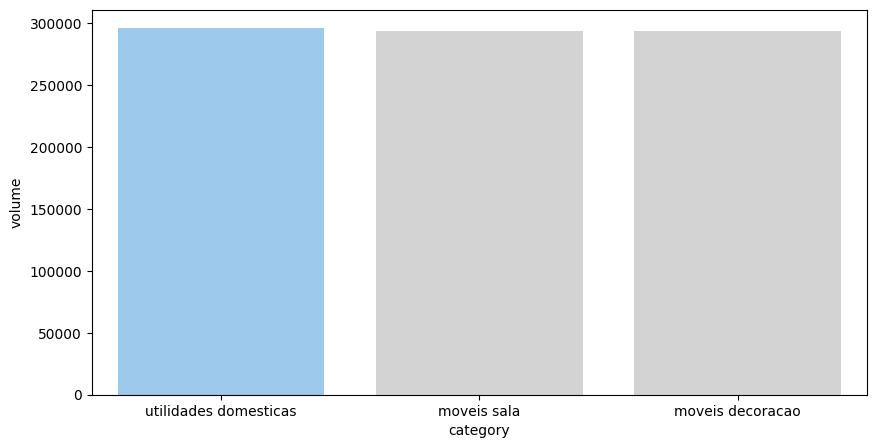

In [34]:
def size(asc):
    product_volume = products[["product_category_name","product_length_cm","product_height_cm","product_width_cm"]]
    product_volume["volume"] = product_volume["product_length_cm"] * product_volume["product_height_cm"] * product_volume["product_width_cm"]
    product_volume = product_volume.sort_values(by="volume",ascending=asc)
    product_volume = product_volume[["product_category_name","volume"]]
    product_volume.columns = ["category","volume"]
    product_volume.reset_index(drop=True,inplace=True)
    return product_volume

product_size = size(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="category", y="volume", data=product_size.head(),
            label="Volume", palette=colors)

## product rating

<Axes: xlabel='category', ylabel='review_score'>

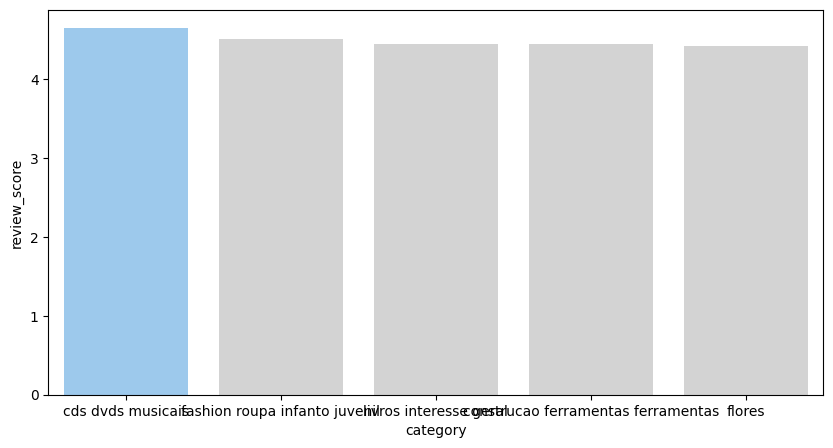

In [35]:
def rating(asc):
    df_rating = order_reviews.merge(order_items,on="order_id")
    df_rating = df_rating[["order_id","review_score","product_id","review_answer_timestamp"]]
    df_rating = df_rating.merge(products,on="product_id")
    df_rating = df_rating[["order_id","review_score","product_id","product_category_name","review_answer_timestamp"]]
    df_rating = df_rating.groupby("product_category_name").review_score.mean().reset_index().sort_values(by="review_score",ascending=asc)
    df_rating.columns = ["category","review_score"]
    df_rating.reset_index(drop=True,inplace=True)
    return df_rating

product_rating = rating(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="category", y="review_score", data=product_rating.head(),
            label="Score", palette=colors)

## customer

<Axes: xlabel='customers', ylabel='city'>

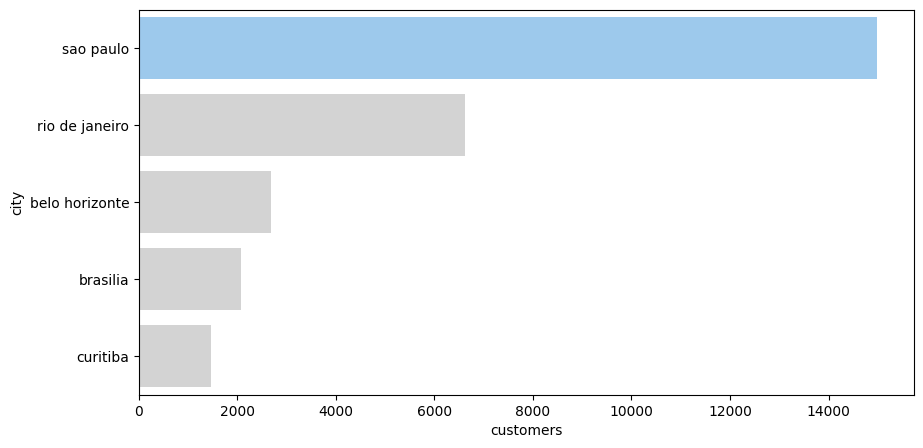

In [37]:
def customer(asc):
    query = "customer_city"
    customers_df = pd.DataFrame(customers.groupby(by=query).customer_unique_id.nunique().sort_values(ascending=asc)).reset_index()
    customers_df.columns=["city","customers"]
    return customers_df

data_customer = customer(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="customers", y="city", data=data_customer.head(5),
            label="Total", palette=colors)

## seller

<Axes: xlabel='seller', ylabel='city'>

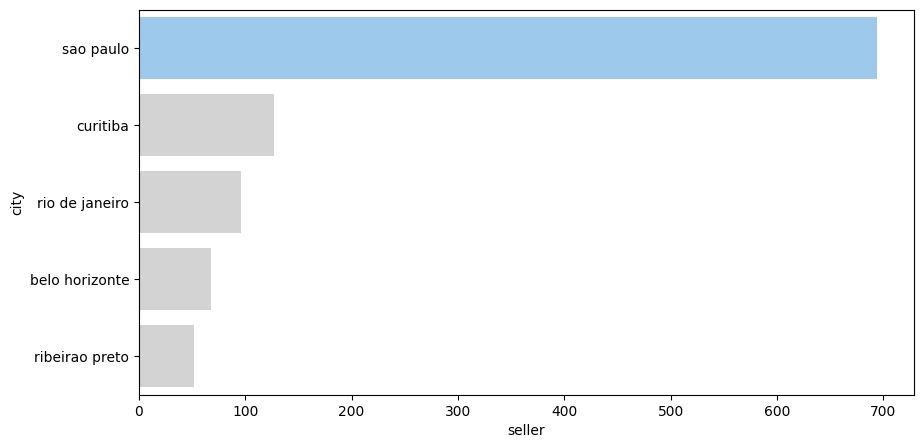

In [39]:
def seller(asc):
    query = "seller_city"
    seller_df = pd.DataFrame(sellers.groupby(by=query).seller_id.nunique().sort_values(ascending=asc)).reset_index()
    seller_df.columns=["city","seller"]
    return seller_df

data_seller = seller(False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="seller", y="city", data=data_seller.head(5),
            label="Total", palette=colors)

## demographic user

<ipython-input-41-71975b163528>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.geometry = points['geometry'].centroid


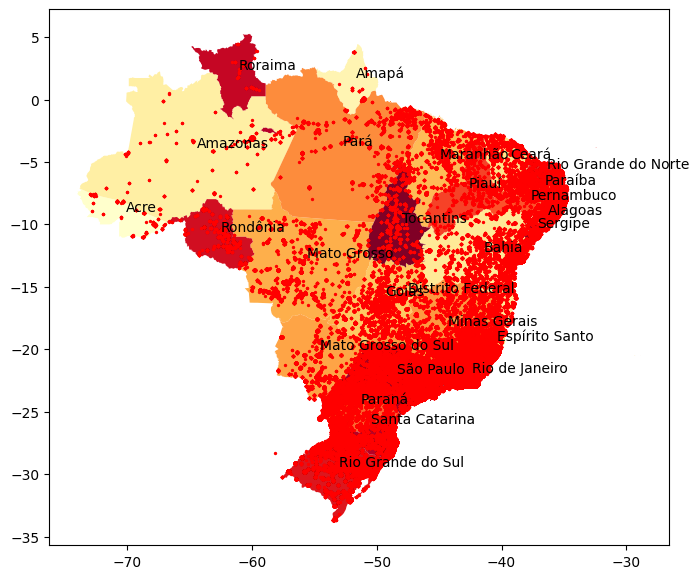

In [41]:
geometry = [Point(xy) for xy in zip(geolocation['geolocation_lng'], geolocation['geolocation_lat'])]
gdf = GeoDataFrame(geolocation, geometry=geometry)

fig, ax = plt.subplots(1, figsize=(8,10))
ax.set_axis_on()

# #this is a simple map that goes with geopandas
brazil = gpd.read_file("brazil/gadm36_BRA_1.shp")
gdf.plot(ax=brazil.plot(ax=ax,cmap='YlOrRd'), marker='o', color='red', markersize=2);


points = brazil.copy()
# change the geometry
points.geometry = points['geometry'].centroid
# Plot the labels
for x, y, label in zip(points.geometry.x, points.geometry.y, points.NAME_1):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), alpha=1, textcoords="offset points",color='black')